# Severstal: Steel Defect Detection

https://www.kaggle.com/c/severstal-steel-defect-detection

In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, sampler
from torchvision import transforms as T
from torchvision import models

from PIL import Image

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime

from severstal_utils import *
from severstal_models import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TRAIN_PATH = 'train_images'
TEST_PATH = 'test_images'
MODEL_PATH = 'models/'
SUBMS_PATH = 'submissions/'


if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

In [4]:
img_mean = (0.3438812517320017,)
img_std = (0.13965334396720055,)

transform_train = T.Compose([
    RandomCrop(FRAME_SIZE),
    RandomVerticalFlip(0.5),
    RandomHorizontalFlip(0.5),
    ToTensor(),
    Normalize(mean=img_mean, std=img_std)
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=img_mean, std=img_std)
])

In [5]:
# Splitting to training and validation parts
imglist = os.listdir(TRAIN_PATH)
imglist_train, imglist_val = train_test_split(imglist, test_size=0.1, random_state=42)

# Datasets
ds_train = ImagesDataset(TRAIN_PATH, imglist_train, masks_csv='train.csv', transform=transform_train)
ds_val = SteelFramesDataset(TRAIN_PATH, imglist_val, masks_csv='train.csv', transform=transform_val)

In [6]:
params_loader = {
    'batch_size': NUM_FRAMES * 2,
    'num_workers': 5,
    'pin_memory': True
}

# Data loaders
loader_train = DataLoader(
    ds_train,
    shuffle=True,
    **params_loader
)
loader_val = DataLoader(
    ds_val,
    shuffle=False,
    **params_loader)

In [7]:
# Model defenition
params_unet = {
    'depth': 5,
    'n_filters': 48,
    'bn': True,
    'activation': 'relu'
}

unet = UnetD(**params_unet)
unet = unet.to(device=device);

detector = Detector(unet, device)

In [ ]:
%%time

params_train = {
    'epochs': NUM_FRAMES * 12,
    'print_every': 0,
    'lr': 0.0001,
}

loss_wts = torch.tensor([1.0, 2.0, 2.0, 1.0, 1.5]).to(device)
loss_fun = torch.nn.CrossEntropyLoss(weight=loss_wts)

detector.fit(loader_train, loader_val, loss_fun, **params_train)

100%|██████████| 808/808 [05:05<00:00,  2.65it/s]

After 1 epochs:
Training loss = 0.7142512839807564



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.3454174011495252
Val Dice score:  0.920622184102082



100%|██████████| 808/808 [05:05<00:00,  2.65it/s]

After 2 epochs:
Training loss = 0.24230215446922235



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.20283617746076038
Val Dice score:  0.9415558899027446



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 3 epochs:
Training loss = 0.16778258439711682



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.15266223838915877
Val Dice score:  0.930639006120398



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 4 epochs:
Training loss = 0.13712385079252257



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.14109233416047898
Val Dice score:  0.9313559098763416



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 5 epochs:
Training loss = 0.12303745116959115



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.12542899190051837
Val Dice score:  0.9363571058783914



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 6 epochs:
Training loss = 0.12187053476541052



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.1221255307591853
Val Dice score:  0.9434369856057512



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 7 epochs:
Training loss = 0.11755081701155246



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.11396163843080176
Val Dice score:  0.9346655548424975



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 8 epochs:
Training loss = 0.11057947384231909



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.10099292667945677
Val Dice score:  0.9407958517305985



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 9 epochs:
Training loss = 0.10320896172805291



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.1028260513391811
Val Dice score:  0.9344307856609069



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 10 epochs:
Training loss = 0.10399908260556355



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.11117410753811387
Val Dice score:  0.9438820944101732



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 11 epochs:
Training loss = 0.0980747032261105



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09790267852300226
Val Dice score:  0.9403239421267877



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 12 epochs:
Training loss = 0.09992269697393186



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09003465058776204
Val Dice score:  0.9299331552563154



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 13 epochs:
Training loss = 0.0964950390628421



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09070805869455684
Val Dice score:  0.9459085977068



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 14 epochs:
Training loss = 0.09619369263201755



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09408080252239373
Val Dice score:  0.9190084680547388



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 15 epochs:
Training loss = 0.08928523653425391



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08574877990585328
Val Dice score:  0.9239363865237816



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 16 epochs:
Training loss = 0.08923336893077022



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09062548022896537
Val Dice score:  0.9475130883112918



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 17 epochs:
Training loss = 0.08765949048124956



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09013536452447629
Val Dice score:  0.9254585165491916



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 18 epochs:
Training loss = 0.08572085682535235



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08832408006983908
Val Dice score:  0.9360215278400157



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 19 epochs:
Training loss = 0.08592517979821168



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08238746544026511
Val Dice score:  0.9464747913318109



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 20 epochs:
Training loss = 0.0839332416893236



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08504167236745218
Val Dice score:  0.9350994551760295



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 21 epochs:
Training loss = 0.08210346345092247



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08342745009674146
Val Dice score:  0.942876347873357



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 22 epochs:
Training loss = 0.07983190506771135



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08536801151936843
Val Dice score:  0.9502464132168602



100%|██████████| 808/808 [05:05<00:00,  2.64it/s]

After 23 epochs:
Training loss = 0.08380617755181556



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08273564172981272
Val Dice score:  0.9276881671748468



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 24 epochs:
Training loss = 0.08119124198300647



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09851009812051921
Val Dice score:  0.9315464589077989



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 25 epochs:
Training loss = 0.07952691603520472



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.13413027025497679
Val Dice score:  0.8913132402284238



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 26 epochs:
Training loss = 0.07576308720852597



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.09604934162672167
Val Dice score:  0.9284694551852551



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 27 epochs:
Training loss = 0.07775248189151863



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07903745597442902
Val Dice score:  0.9440624616690448



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 28 epochs:
Training loss = 0.07864990675148871



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07360953928241669
Val Dice score:  0.9414348998236676



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 29 epochs:
Training loss = 0.07704336480364755



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08138078039739127
Val Dice score:  0.9040161081980217



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 30 epochs:
Training loss = 0.0738579932084496



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07235994900476933
Val Dice score:  0.9442387602589106



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 31 epochs:
Training loss = 0.07335416410916523



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07628023026293616
Val Dice score:  0.9412716137291234



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 32 epochs:
Training loss = 0.07446758331416925



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07625164361555772
Val Dice score:  0.9383336256777567



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 33 epochs:
Training loss = 0.0720615329764485



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07531298944856615
Val Dice score:  0.9460731932068023



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 34 epochs:
Training loss = 0.07325481769428989



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07279203751362644
Val Dice score:  0.919461674033979



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 35 epochs:
Training loss = 0.07240944696357618



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07457598392665868
Val Dice score:  0.9488753566878507



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 36 epochs:
Training loss = 0.07241223812642254



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07116356468259363
Val Dice score:  0.938987186814265



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 37 epochs:
Training loss = 0.0670388467709017



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07124429534848997
Val Dice score:  0.9388188067749558



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 38 epochs:
Training loss = 0.06956466235291736



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.0730322732535219
Val Dice score:  0.9402731826311079



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 39 epochs:
Training loss = 0.0691759362285732



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06892824115983841
Val Dice score:  0.9399624030648855



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 40 epochs:
Training loss = 0.07154990125869246



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07129553708686089
Val Dice score:  0.9385204015976869



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 41 epochs:
Training loss = 0.06873097872492787



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06820639317752253
Val Dice score:  0.9471325484077041



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 42 epochs:
Training loss = 0.07050238887866446



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07346300623751399
Val Dice score:  0.9478520682243098



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 43 epochs:
Training loss = 0.06815421058917465



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06925744495108055
Val Dice score:  0.9349892626893643



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 44 epochs:
Training loss = 0.06619010708447874



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06582280315835527
Val Dice score:  0.9484264737761201



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 45 epochs:
Training loss = 0.06515704351277656



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07120124148201218
Val Dice score:  0.9408637062367126



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 46 epochs:
Training loss = 0.0668503806999426



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06788100679550436
Val Dice score:  0.9448507816998277



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 47 epochs:
Training loss = 0.06656512096817362



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.07018138393459196
Val Dice score:  0.9438898313965415



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 48 epochs:
Training loss = 0.06609373062738465



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06818569932545461
Val Dice score:  0.9361213590763064



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 49 epochs:
Training loss = 0.06445914618829852



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06325992492796088
Val Dice score:  0.9533837049749037



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 50 epochs:
Training loss = 0.06676069403815023



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06666292823647729
Val Dice score:  0.9471178918768701



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 51 epochs:
Training loss = 0.06699765051433727



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06915310045261368
Val Dice score:  0.935774106493808



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 52 epochs:
Training loss = 0.06320464125379983



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06510832381428071
Val Dice score:  0.9585224437448081



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 53 epochs:
Training loss = 0.05944253097914654



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.0655123418055198
Val Dice score:  0.936757292980795



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 54 epochs:
Training loss = 0.06550901978809477



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.08164580769099421
Val Dice score:  0.9440601924723259



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 55 epochs:
Training loss = 0.06388241799735833



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06601756618556573
Val Dice score:  0.9469604668583107



100%|██████████| 808/808 [05:06<00:00,  2.64it/s]

After 56 epochs:
Training loss = 0.062408981626711234



  0%|          | 0/808 [00:00<?, ?it/s]

Validation loss: 0.06305637171598671
Val Dice score:  0.9517176136576001



  7%|▋         | 56/808 [00:21<04:46,  2.63it/s]

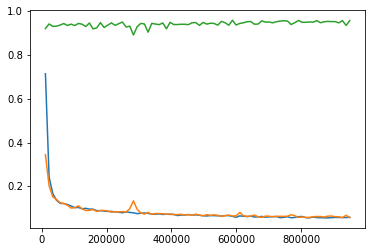

In [13]:
plt.plot(
    detector.n_frames, detector.loss_history,
    detector.n_frames, detector.val_loss_history,
    detector.n_frames, detector.val_dice_history
);

In [ ]:
# Save weights
# Final state
datestr = datetime.now().strftime('%Y%m%d')
fname_wts_final = f"{datestr}_unetd_D{params_unet['depth']}F{params_unet['n_filters']}E{params_train['epochs']}_final.pth"
torch.save(detector.model.state_dict(), os.path.join(MODEL_PATH, fname_wts_final))

# Best weights
fname_wts_best = f"{datestr}_unetd_D{params_unet['depth']}F{params_unet['n_filters']}E{params_train['epochs']}_best.pth"
torch.save(detector.best_model_wts, os.path.join(MODEL_PATH, fname_wts_best))

In [ ]:
# Load weights
detector.model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'unetd_D5F16E1_final.pth')))

## Draft